# Установка пакетов

In [ ]:
from google.colab import drive # скачал датасет на диск
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install open_clip_torch matplotlib torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 60.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x

# Подготовка модели

In [ ]:
import os, random
os.environ["CUDA_VISIBLE_DEVICES"] = ""
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import open_clip # для загрузки модели
import IPython.display
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from PIL import Image
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
model, preprocess = open_clip.create_model_from_pretrained('hf-hub:timm/ViT-B-16-SigLIP') # Выбрал модель SigLIP
tokenizer = open_clip.get_tokenizer('hf-hub:timm/ViT-B-16-SigLIP') # Токенизатор для модели
model.eval()
path = 'drive/MyDrive/Colab Notebooks/TestTask/Flickr30k/flickr30k-images/' # Путь до датасета
print(' ')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


open_clip_pytorch_model.bin:   0%|          | 0.00/813M [00:00<?, ?B/s]

open_clip_config.json:   0%|          | 0.00/881 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/20.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

In [ ]:
# Параметры модели
cl = model.context_length
print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Context length:", cl)
print("Vocab size:", model.vocab_size)
#preprocess

Model parameters: 203,155,970
Context length: 64
Vocab size: 32000


In [ ]:
tokenizer("Hello World!")

tensor([[14647,   459,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1]])

# Zero-shoot classification
Классификатор без размеченного датасета на основе обученной модели LIP

In [ ]:
print(len(os.listdir(path)))
original_images = [] # Для изображений PIL
images = []          # Для изображений torch
# Беру часть изображений в форматах PIL и torch tensor для экономии ресурсов
for filename in random.sample(os.listdir(path),1000):
  if filename.split('.')[-1]!='txt':
    image = Image.open(path+filename).convert("RGB")
    original_images.append(image)
    images.append(preprocess(image))

31734


In [ ]:
# Метки классификации
texts = ['people out on a walk', 'a sport activitie','children play',
         'people take a chill', 'people working hard']

In [ ]:
# Изображения и метки переходят в нужный формат для модели
image_input = torch.tensor(np.stack(images))
text_tokens = tokenizer(["This is " + desc for desc in texts],context_length=cl)
image_input.shape,text_tokens.shape

(torch.Size([1000, 3, 224, 224]), torch.Size([5, 64]))

In [ ]:
# Модель переводит текст и изображения в общее пространство размерностью 768
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()
# Нормализация векторов, чтобы взять косинус угла между векторами и определить схожесть векторов текста и изображений
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
image_features.shape,text_features.shape

(torch.Size([1000, 768]), torch.Size([5, 768]))

In [ ]:
def classificate_image(original_images, image_features, text_features): # Функция классификатора
  ''' # Рисует матрицу косинуса
  similarity =(text_features.cpu() @ image_features.cpu().T).softmax(dim=-2)
  similarity = similarity.numpy()
  count = text_features.shape[0]
  plt.figure(figsize=(20, 14))
  plt.imshow(similarity, vmin=np.min(similarity), vmax=np.max(similarity))
  plt.colorbar()
  plt.yticks(range(count), texts, fontsize=18)
  plt.xticks([])
  for i, image in enumerate(original_images):
      plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
  for x in range(similarity.shape[1]):
      for y in range(similarity.shape[0]):
          plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)
  for side in ["left", "top", "right", "bottom"]:
    plt.gca().spines[side].set_visible(False)
  plt.xlim([-0.5, similarity.shape[1] - 0.5])
  plt.ylim([similarity.shape[0] + 0.5, -2])
  plt.title("Cosine similarity between text and image features", size=20)
  '''
  # Чем меньше модуль угла между векторами, тем больше косинус
  text_probs = (100.0 * image_features @ text_features.T)# Вычисление косинусов между векторами изображений и меток
  text_probs = text_probs.softmax(dim=-1)# Перевод косинусов в вероятности принадлижания к меткам
  # Для каждого изображения выбираются 4 наиболее вероятные метки
  top_probs, top_labels = text_probs.cpu().topk(4, dim=-1)
  # Отрисовка результатов классификации
  plt.figure(figsize=(16, 16))
  for i, image in enumerate(original_images):
      plt.subplot(8, 4, 2 * i + 1)
      plt.imshow(image)
      plt.axis("off")
      plt.subplot(8, 4, 2 * i + 2)
      y = np.arange(top_probs.shape[-1])
      plt.grid()
      plt.barh(y, top_probs[i])
      plt.gca().invert_yaxis()
      plt.gca().set_axisbelow(True)
      plt.yticks(y, [texts[j] for j in top_labels[i]])
      plt.xlabel("probability")
  plt.subplots_adjust(wspace=0.5)
  plt.show()

In [ ]:
# Вызов функции классификатора для 16 случайных изображений
indexes = [random.randint(0,image_features.shape[0]-1) for i in range(16)]
oi = [original_images[i] for i in indexes]
imf = torch.tensor(np.stack([image_features[i] for i in indexes]))
classificate_image(oi,imf,text_features)

Output hidden; open in https://colab.research.google.com to view.

# Retrieval task
Поиск наиболее подходящего запросу изображения

In [ ]:
# Запросы и перевод в токены
requests = ['people play football','poeple run marathon','people play basketball','senior citizens','people play baseball']
req_tokens = tokenizer(requests,context_length=cl)

In [ ]:
# Преобразование запросов в эмбеддинг
with torch.no_grad():
    req_features = model.encode_text(req_tokens).float()
req_features /= req_features.norm(dim=-1, keepdim=True)
req_features.shape,image_features.shape

(torch.Size([5, 768]), torch.Size([1000, 768]))

In [ ]:
# Матрица s из косинусов углов между векторами, как параметр схожести изображения и запросов
s = (image_features@req_features.T )
s = s.T.numpy()
s.shape

(5, 1000)

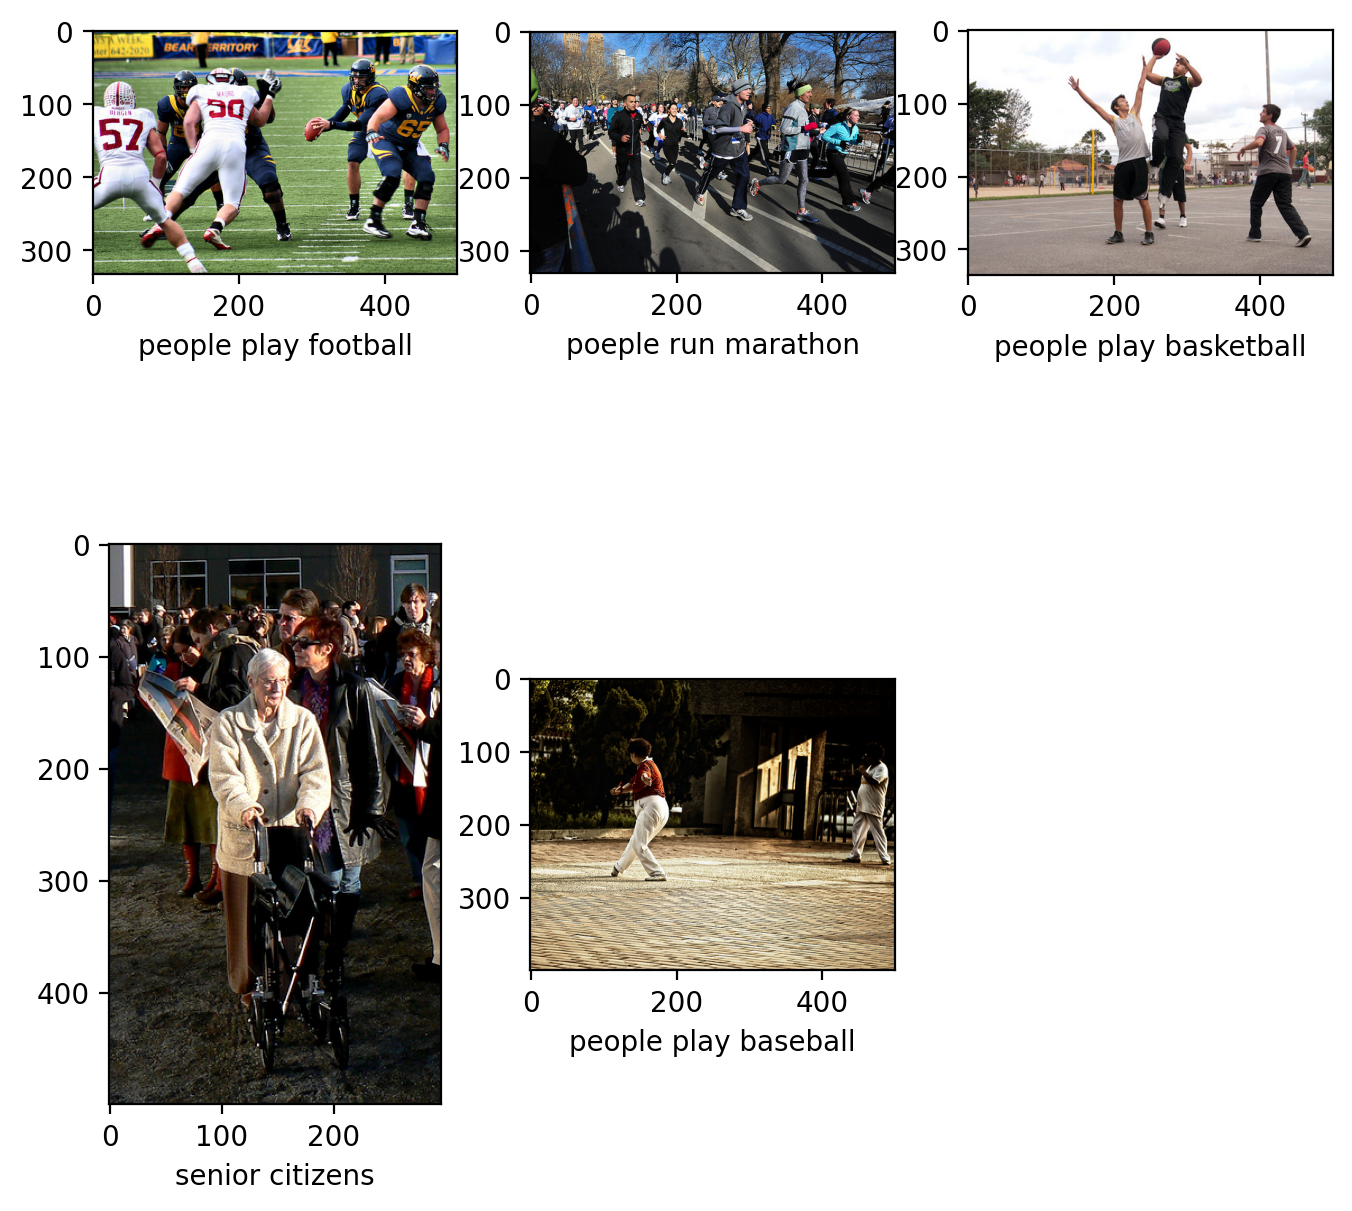

In [ ]:
# Демонстрация запросов и наиболее подходящих изображений
d = {} # Словарь для 10 элементов, наиболее соответсвующих текстовым запросам
plt.figure(figsize=(8, 8))
for i in range(len(requests)):
  im = sorted(zip(s[i],range(len(s[i]))))[::-1] # Получение индексов подходящих изображений сортировкой по вероятностям в матрице s
  d[requests[i]] = [i[1] for i in im[:10]] # Запись в словарь
  im = im[0][1]
  plt.subplot(2, len(requests)//2+len(requests)%2, i+1)
  plt.imshow(original_images[im])
  plt.xlabel(requests[i])

In [ ]:
# Ближайшие изображения одного запроса
plt.figure(figsize=(16,16))
x = random.choice(list(d.keys()))
for k,i in enumerate(d[x][:5]):
  plt.subplot(1,5,k+1)
  plt.title(x)
  plt.imshow(original_images[i])

Output hidden; open in https://colab.research.google.com to view.

# Визуализация эмбеддингов
Не совсем понял, как визуализировать вектора большой размерности, я решил сжать вектора до двумерных, воспользовавшись методом главных компонент, и отобразить их на графике

In [ ]:
cov_matrix = image_features.T @ image_features # Матрица ковариации
eigenvalues, eigenvectors = torch.linalg.eig(cov_matrix) # Отсортированные по собственным значениям списки
eigenvalues = torch.real(eigenvalues) # torch.linalg.eig вернул в мнимых числах
pc = torch.real(eigenvectors[:2]) # Первые две главные компоненты
imvec = pc @ image_features.T # Проекция векторов на главные компоненты

In [ ]:
print(sorted(eigenvalues)[::-1][:20])

[tensor(514.8581), tensor(28.4252), tensor(17.8828), tensor(16.8342), tensor(14.7441), tensor(13.6734), tensor(11.8699), tensor(11.0819), tensor(10.3850), tensor(9.4935), tensor(8.7102), tensor(8.0493), tensor(7.5184), tensor(7.0024), tensor(6.9460), tensor(6.2246), tensor(6.0045), tensor(5.5944), tensor(5.2403), tensor(4.9515)]


Соответвующие собственные значения первым двум главным компонентам значительно больше других собственных значений, значит двумерного вектора должно хватить, чтобы охарактеризовать изображения

Визуализация векторов эмбеддинга для изображений, полученных задачей retrieval

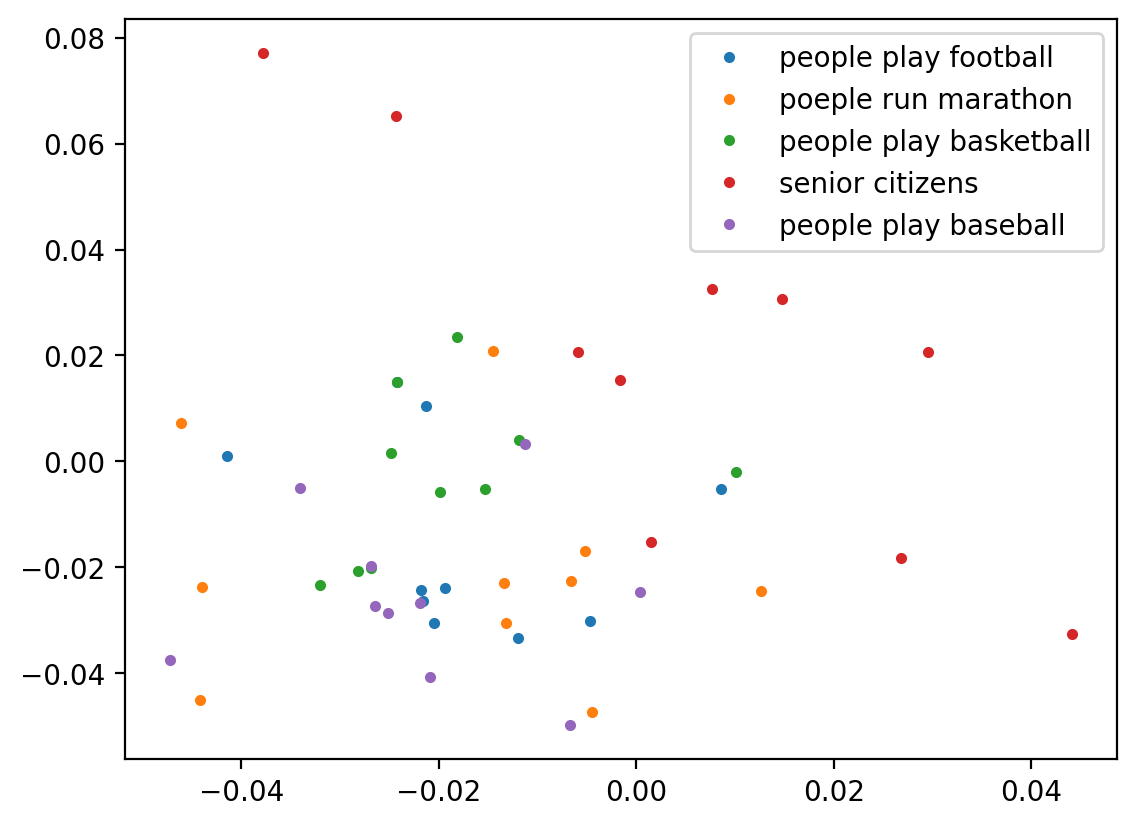

In [ ]:
for i in d.items():
  plt.plot(imvec[0][i[1]],imvec[1][i[1]],'.',label = i[0])
  plt.legend()

Одинаковые по смыслу изображения занимают определенную область в эмбеддинг пространстве:

Вектора меток консолидируются, можно заметить, что изображения people run marathon разбросаны сильнее всего, так как деятельность характерна для других меток.
Также видно, что метки senior citizens не пересекаются с спортивными активностями

собственные зоны в эмбеддинг пространстве

# VLAttack

Visual Language attack: поиск слепых зон модели; Поиск изображения схожего с оригинальным, но не распознавемым для модели

In [ ]:
# Получение изображений формата torch по запросу 'people play football'
d = {}
plt.figure(figsize=(8, 8))
for i in range(len(requests)):
  im = sorted(zip(s[i],range(len(s[i]))))[::-1]
  d[requests[i]] = [i[1] for i in im[:1]]
I = [preprocess(original_images[i]) for i in d['people play football']]
N=1000
sigma = 0.1

<Figure size 800x800 with 0 Axes>

In [ ]:
I[0].shape

torch.Size([3, 224, 224])

In [ ]:
I = torch.tensor(np.stack(I))
text_tokens = tokenizer(["people play football"],context_length=cl)

Оригинальное изображение и измененное должны иметь маленький косинус угла между ними в эмбеддинг представлении

In [ ]:
with torch.no_grad():
  labels  = model.encode_text(text_tokens).float()
  labels /= labels.norm(dim=-1, keepdim=True)
F_alpha = model.encode_image   # F_alpha - энкодер, F_beta -  Transformer encoder
def F_beta(x,labels = labels): # Возвращает вероятность принадлежания классу
  return (labels @ x.T).softmax(dim=-1)
I_alpha  = F_alpha(I)
I_alpha /= I_alpha.norm(dim=-1, keepdim=True)
I_beta   = F_beta(I_alpha)
def BSAloss(I1emb,I_alpha = I_alpha,I_beta=I_beta): # Ошибка считающая сумму косинусов между эмбеддингами текстов и изображений
  loss = sum(I1emb@I_alpha.T) +sum(F_beta(I1emb) @I_beta.T)
  return sum(loss)
BSAloss(I_alpha)

tensor(2., grad_fn=<AddBackward0>)

In [ ]:
r = torch.randn(*I.shape, requires_grad=True)
optimizer = optim.Adam([r], lr=0.001)
for i in range(N):  # Цикл оптимизации
    I1 = I+(torch.sigmoid(r)-0.5)*sigma # I1 = I+dI1, dI1<=sigma - предел отклонения
    output = F_alpha(I1)
    I_alpha_copy = I_alpha.detach().clone()
    I_beta_copy = I_beta.detach().clone()
    z= output /output.norm(dim=-1, keepdim=True)
    loss = BSAloss(z,I_alpha = I_alpha_copy,I_beta=I_beta_copy)
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    if i%100==0:
      print("Iteration {}, Loss: {}".format(i, loss.item()))

Iteration 0, Loss: 1.9928261041641235
Iteration 100, Loss: 1.9317359924316406
Iteration 200, Loss: 1.8714253902435303
Iteration 300, Loss: 1.8146018981933594
Iteration 400, Loss: 1.7637898921966553
Iteration 500, Loss: 1.7096617221832275
Iteration 600, Loss: 1.6446329355239868
Iteration 700, Loss: 1.5765117406845093
Iteration 800, Loss: 1.490769863128662
Iteration 900, Loss: 1.4008276462554932


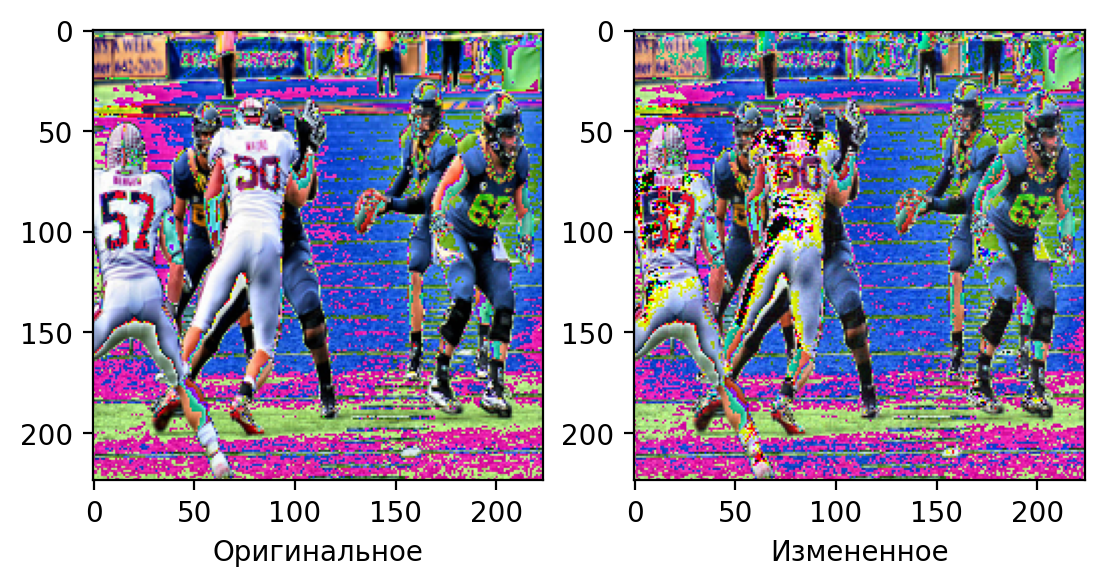

In [ ]:
to_pil = transforms.ToPILImage()
plt.subplot(1,2,1)
plt.imshow(to_pil(I[0]))
plt.xlabel('Оригинальное')
plt.subplot(1,2,2)
plt.xlabel('Измененное')
plt.imshow(to_pil( (torch.sigmoid(r)*sigma+I)[0] ))